# Controlling Plotting Functions

We start with some basic, universal loading and setup.
This is the same in all how-tos and tutorials, so that there is a unified set of data to work with.

## Initial FRETBursts analysis, skip to [here](#cplot) to skip to how to section

> Download the example file here: [HP3_TE300_SPC630.hdf5](https://zenodo.org/record/5902313/files/HP3_TE300_SPC630.hdf5)

First let's import the necessary modules:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import fretbursts as frb
import burstH2MM as bhm

sns = frb.init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7.1).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


Load the data and search for bursts:

In [2]:
filename = 'HP3_TE300_SPC630.hdf5'
# load the data into the data object frbdata
frbdata = frb.loader.photon_hdf5(filename)

Check the alternation period etc.:

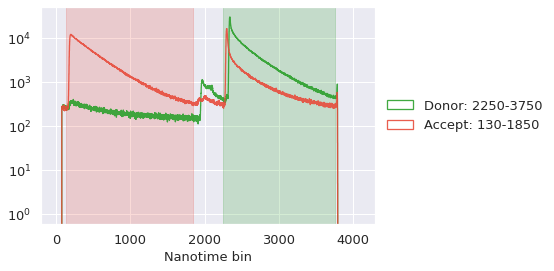

In [3]:
# plot the alternation histogram
frb.bpl.plot_alternation_hist(frbdata)

If the alternation period looks good, we can apply the alternation period to assign Donor/Acceptor excitation to each photon:

In [4]:
# if the alternation period is correct, apply data
frb.loader.alex_apply_period(frbdata)

# Total photons (after ALEX selection):    11,414,157
#  D  photons in D+A excitation periods:    5,208,392
#  A  photons in D+A excitation periods:    6,205,765
# D+A photons in  D  excitation period:     6,611,308
# D+A photons in  A  excitation period:     4,802,849



Calculate the background rates used to set thresholds for finding bursts:

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]


<AxesSubplot:title={'center':'HP3_TE300_SPC630'}, xlabel='Inter-photon delays (ms)', ylabel='# Delays'>

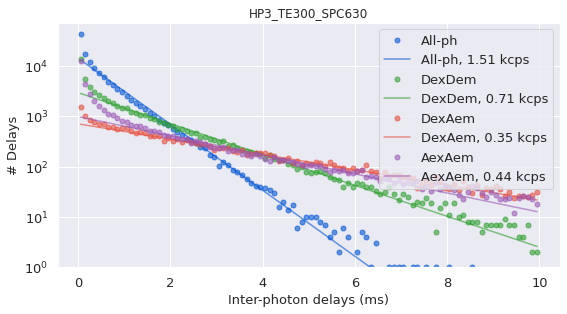

In [5]:
# calcualte the background rate
frbdata.calc_bg(frb.bg.exp_fit, F_bg=1.7)
# plot bg parameters, to verify quality
frb.dplot(frbdata, frb.hist_bg)

And finally search for bursts and refine the selection by appropriate burst size/width/other parameters:

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
<class 'matplotlib.figure.Figure'>


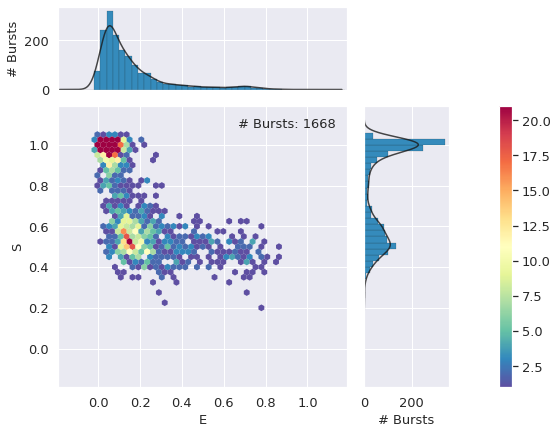

In [6]:
# now perform burst search
frbdata.burst_search(m=10, F=6)
# make sure to set the appropriate thresholds of ALL size
# parameters to the particulars of your experiment
frbdata_sel = frbdata.select_bursts(frb.select_bursts.size, th1=50)

frb.alex_jointplot(frbdata_sel);

Now that the data is selected, we can segment the photons into bursts, which will be stored in a BurstData object, and optimize the models:

In [7]:
bdata = bhm.BurstData(frbdata_sel)
# calculate models
bdata.models.calc_models()

The model converged after 1 iterations

The model converged after 35 iterations

The model converged after 122 iterations

The model converged after 395 iterations

2

<a id='cplot'></a>
# Customizing state plotting

The central plotting functions of burstH2MM are all highly customizable.

The first and simplest form of customization is using the `ax` keyword argument, which is universal to all plotting functions. 
This lets you make a `matplotlix.axes.Axes` (usually made with `plt.subplots()` or related functions), and then plot all elements within that axes. 
This also lets overlapping different plots into one axes.

So here’s an example, and we’ll set the title of the axes afterward:

Text(0.5, 1.0, 'Dwell Based Results')

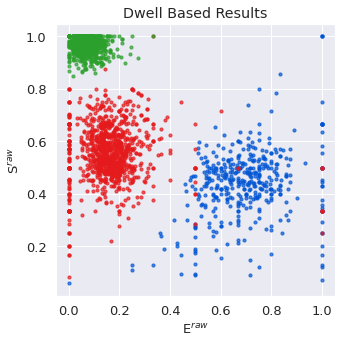

In [8]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))
bhm.dwell_ES_scatter(bdata.models[2], ax=ax)
ax.set_title("Dwell Based Results")

For E and S based parameters, there is the option to use the raw values (calculated from the photons alone), or the values corrected for the values set for leakage, direct excitation, *gamma* and *beta* that have been set in the `fretbursts.Data` object used to create the BurstData object that you are working on. 
For dwell based parameters, corrections for background are also applied.

> **Note**
>
> See the [On demand data creation section](https://bursth2mm.readthedocs.io/en/latest/Discussion.html#datacreation) to understand how, and most importantly when parameters are calculated. 
> Make sure that your `leakage`, `dir_ex`, `gamma` and `beta` values are set before you try to plot or otherwise access any dwell value that involves correcting for these factors. 
> If you want to recalculate, use the `H2MM_result.trim_data()` method on your `H2MM_result` object to clear the value:

This is done quite simply using the `add_corrections` keyword argument:

   - Applying background correction.
   - Applying leakage correction.
   - Applying background correction.
   - Applying leakage correction.
   - Applying direct excitation correction.


(-0.2, 1.2)

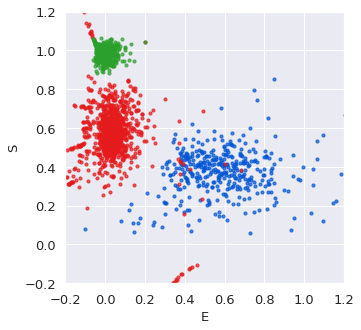

In [9]:
# trim data, NOT necessary if corrected values have not been accessed yet
bdata.models[2].trim_data()

fig, ax = plt.subplots(figsize=(5,5))
# add correction factors (determine for your own setup)

bdata.data.leakage = 0.0603
bdata.data.dir_ex = 0.0471
bdata.data.gamma = 1.8
bdata.data.beta = 0.69
# note the addition of add_corrections=True
bhm.dwell_ES_scatter(bdata.models[2], add_corrections=True, ax=ax)
# set limits on the values, since with corrections, some dwells with
# few photons in a stream will have extreme values
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])

# Customizing plots by state

Additional customizations focus on how states are individually plotted. 
This is done by passing lists of keyword argument dictionaries to specific keyword arguments.

The first of these keyword arguments we will explore is `state_kwargs`. 
This is universal to all plotting functions beginning with `dwell_`. 
For it you pass a list of dictionaries of keyword arguments for the underlying matploplib function, one dictionary for each state.

Here’s a simple example, where we assign a color to each state in the `dwell_ES_scatter()` plot:

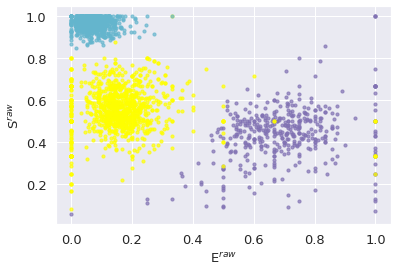

In [10]:
# set up list, same length as number of states in the model
state_color = [{'color':'m'}, {'color':'yellow'}, {'color':'c'}]
bhm.dwell_ES_scatter(bdata.models[2], state_kwargs=state_color)

So what happened here? Since models[2] has 3 states, the input state_kwargs keyword argument needs to be a list or tuple of length 3. The model stores states in arrays, which gives the states an arbitrary order. Each element of the list is passed per state to the matplotlib plt.scatter()_ function as **kwargs, according to the order established in the model. So the first state gets the keyword argument color='m', the second state color='yellow' and the third color='m'.

> **Note**
> 
> The different plotting functions use different matplotlib and seaborn functions. 
> So plotting functions that create histograms use `plt.hist()`, while scatter functions use `plt.scatter()`, and kde plot functions use `sns.kdeplot()`

# Only displaying certain states

What if you want to only look at a few states? 
You can select, and control the order of the plotting of different states with the states keyword argument.

Let’s say we want to only look at the FRET states (which are the 0th and 1st states in sample data set, but might be different when you are using other datasets). 
To do this, we make an array of just the indices of those states, and then pass that array to the states keyword argument:

Text(0.5, 1.0, 'FRET states')

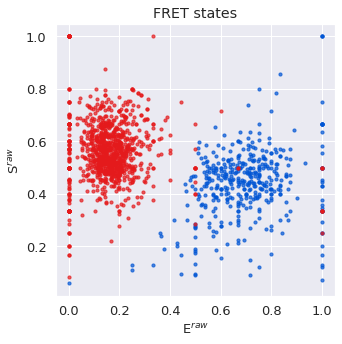

In [11]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))

# specify the states we want
states = np.array([0, 1])

# now we plot
bhm.dwell_ES_scatter(bdata.models[2], ax=ax, states=states)
ax.set_title("FRET states")

## Selecting states and controlling their plotting

So how do we combine the states and `state_kwargs`? 
It’s pretty simple, states serves like a “master”, and so each state specified in states is matched with an element of `state_kwargs`, assuming they come in the same order. 
So, you specify `state_kwargs` dictionaries in the same order as the states you specify in states, and obviously, they need to be the same length, otherwise you will get an error.

So here’s an example where we re-plot the FRET states, but in reverse order, and see how the `state_kwargs` are also reordered:

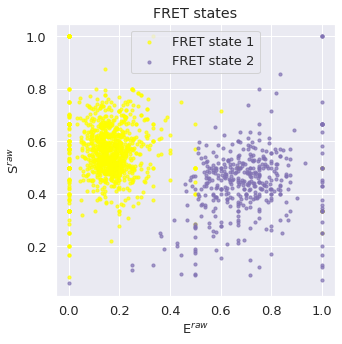

In [12]:
# make the axes
fig, ax = plt.subplots(figsize=(5,5))

# specify the states we want, now with 1 before 0
states = np.array([1, 0])
# make the state_kwargs, we'll add labels this time
state_kwargs = [{'color':'yellow', 'label':'FRET state 1'}, {'color':'m', 'label':'FRET state 2'}]

# now we plot
bhm.dwell_ES_scatter(bdata.models[2], ax=ax, states=states, state_kwargs=state_kwargs)

# add title, and legend to the plot
ax.set_title("FRET states")
ax.legend()

# Selecting photon streams

But what about the `H2MM_result.dwell_nano_mean` parameter? 
It has not only information per state, but also information per stream. 
Some other dwell parameters are similar. 
To select and/or specify a stream, we have the streams keyword argument, and the `stream_kwargs` keyword argument to customize those plotting for those functions as well. 
For this we will use the `dwell_tau_hist()` function.

#### But first we must set the `irf_thresh`:

> This should be done once, before a paremeter based on nanotimes is accessed

In [13]:
bdata.irf_thresh = np.array([2355, 2305, 220])

Now we can see the default appearance of `dwell_tau_hist()`:

[[<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>]]

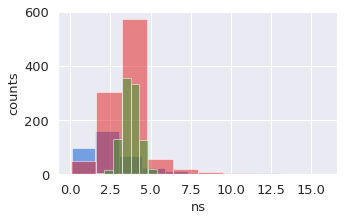

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
bhm.dwell_tau_hist(bdata.models[2], ax=ax)

By default, `dwell_tau_hist()` only shows the mean nanotimes for the D<sub>ex</sub>D<sub>em</sub> photon stream. 
But what if we wanted to look at a different stream? 
To do this we use the `streams` keyword argument. 
It functions like the `states` keyword argument before.

So, let’s look at the D<sub>ex</sub>D<sub>em</sub> and D<sub>ex</sub>A<sub>em</sub> streams:

[[<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>]]

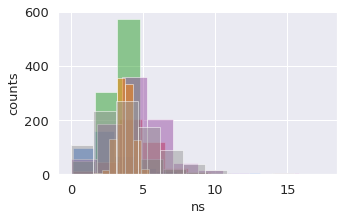

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams)

Or just the D<sub>ex</sub>A<sub>em</sub> stream:

[[<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>]]

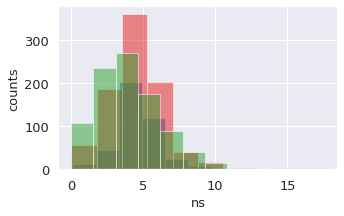

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Aem")]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams)

# Customizing plotting of photon streams

For plots where there are specific selections per stream in addition to per state, the `stream_kwargs` keyword argument exists. 
It functions much like the `state_kwargs` argument, matching the order of streams and needing to be the same length.

Also, `state_kwargs` and `stream_kwargs` merge dictionaries, so you can specify both, and not have a problem.

So let’s see an example:

[[<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>]]

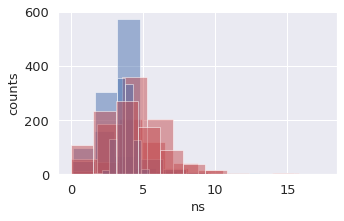

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw)

But now, the problem is we have no idea which state goes with what, so let’s use the `states` keyword argument to specify only the 0th state:

[[<BarContainer object of 10 artists>, <BarContainer object of 10 artists>]]

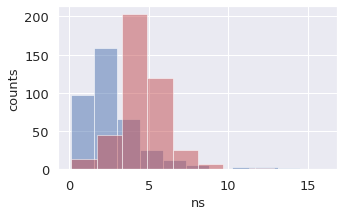

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
state = np.array([0])
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw, states=state)

Finally, `stream_kwargs` and `state_kwargs` work together: the two dictionaries for a particular stream and state combination are merged:

> **Note**
> 
> In the dictionary merging process, if the same key is present in both dictionaries, then the value in `stream_kwargs` will be used, and the values in `state_kwargs` over-written.

[[<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>],
 [<BarContainer object of 10 artists>, <BarContainer object of 10 artists>]]

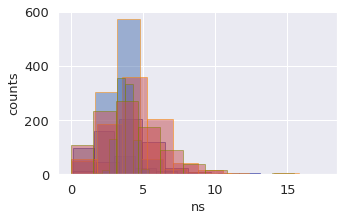

In [19]:
fig, ax = plt.subplots(figsize=(5, 3))
streams = [frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Dex="Aem")]
stream_kw = [{'color':'b'}, {'color':'r'}]
state_kw = [{'edgecolor':'darkblue'}, {'edgecolor':'darkorange'}, {'edgecolor':'olive'}]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, streams=streams, stream_kwargs=stream_kw, state_kwargs=state_kw)

# Plotting state and stream specific plotting in one array

Now, sometimes you need even more control, because the two keyword argument arrays clash. For this there is the kwarg_arr keyword argument. In kwarg_arr, you provide an array of dictionaries that will be the keyword arguments for plt.scatter()_ , the outer dimension indicates which state, and the inner dimension indicates which the stream.

> **Note**
> 
> `kwarg_arr` is meant to take the place of the combination of `state_kwargs` and `stream_kwargs`. 
> As such, `kwarg_arr` and `state_kwargs` cannot be specified at the same time. If `stream_kwargs` is specified at the same time as `kwarg_arr`, then burstH2MM will make a check. 
> If `kwarg_arr` is formatted like `state_kwargs`, then it will be treated like `state_kwargs`. 
> On the other hand, if it is formatted as demonstrated below, `stream_kwargs` will be ignored, and a warning will be presented.

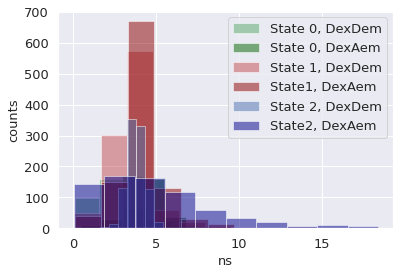

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
kwarr = [[{'color':'g', 'label':'State 0, DexDem'},
          {'color':'darkgreen', 'label':'State 0, DexAem'}],
         [{'color':'r', 'label':'State 1, DexDem'},
          {'color':'darkred', 'label':'State1, DexAem'}],
         [{'color':'b', 'label':'State 2, DexDem'},
          {'color':'darkblue', 'label':'State2, DexAem'}]]
bhm.dwell_tau_hist(bdata.models[2], ax=ax, kwarg_arr=kwarr, streams=[frb.Ph_sel(Dex="Dem"), frb.Ph_sel(Aex="Aem")])
ax.legend()

So `kwarg_arr` allows the most customization, but is also the longest to define.

# Plotting only dwells of certain position and other masking

Dwell based plotting functions also include the `dwell_pos` keyword arguments. 
This arguments allows the user to filter which dwells are plotted, not by state, but by the position (middle of the burst, start, stop or whole), and in its most advanced usage, by any user defined criterion. 
There are several possible types of inputs to `dwell_pos`, but the most easily understood is by using one of the [Masking](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#module-burstH2MM.Masking) functions (see [Using masking functions to make masks](https://bursth2mm.readthedocs.io/en/latest/AccessResult.html#maskexplanation)).

So let’s see `dwell_pos` in action:

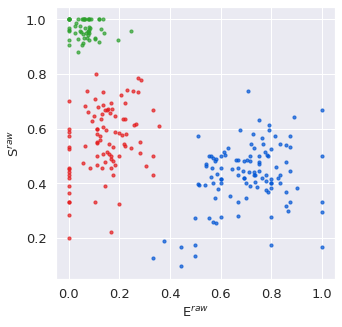

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=bhm.mid_dwell, ax=ax)

> **Note**
> 
> Functions handed to `dwell_pos` must accept a `H2MM_result` object as input, and return a mask of dwells

You will note many fewer points, as there are many beginning, ending and whole burst dwells removed.

It is also possible to specify dwells by specifying `dwell_pos` as an integer corresponding to the dwell position code used in the similarly named `H2MM_result.dwell_pos` parameter.

So to select the mid dwells, we give it 0:

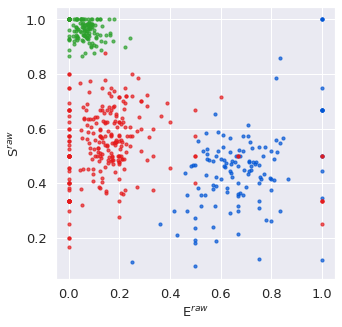

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=1, ax=ax)

And to select the beginning of bursts:

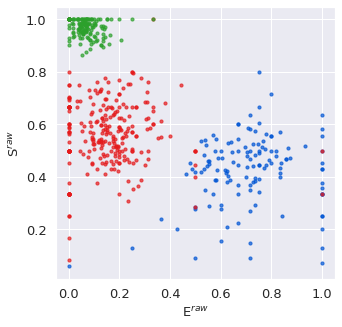

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
# plot only dwells in the middle of a burst
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=2, ax=ax)

It is also possible to select multiple types of dwells by using an array of all interested codes:

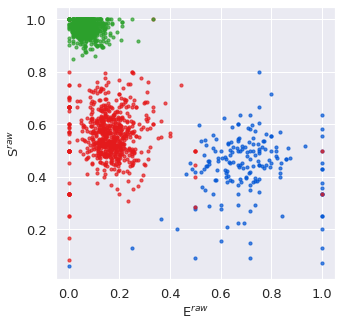

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
# make array of code selections (beginning and whole burst dwells)
pos_sel = np.array([2,3])
# plot the selection
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=pos_sel, ax=ax)

Another method is to provide a mask of all the dwells, for example, all dwells with a stoichiometry greater than some threshold:

(0.0, 1.0)

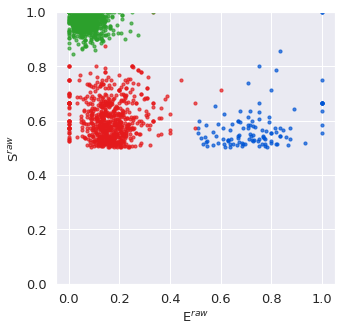

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
# make mask of dwells with stoichiometry greater than 0.5
dwell_mask = bdata.models[2].dwell_S > 0.5
# plot with a mask
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos=dwell_mask, ax=ax)
# ensure full S range is plotted
ax.set_ylim([0,1])

Now the previous example plots a selection that is not very useful, however, what if we want to exclude dwells with fewer than a certain number of photons? 
Well, you could use `H2MM_result.dwell_ph_counts` to make a mask, but there is one [Masking](https://bursth2mm.readthedocs.io/en/latest/Documentation.html#module-burstH2MM.Masking) function that is different from the others, and will not work directly as an input to `dwell_pos`: this is `dwell_size()` which needs at least a minimum number of photons as input. 
So here, we will employ a Python `lambda` function:

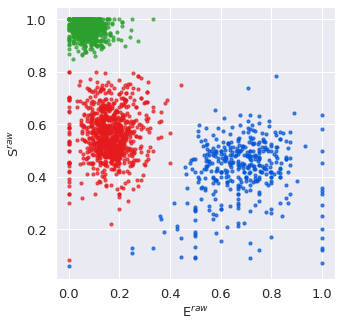

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
# plot with lambda function, sets ph_min at 10
bhm.dwell_ES_scatter(bdata.models[2], dwell_pos= lambda m: bhm.dwell_size(m, 10), ax=ax)

Thus you can hand functions that take `H2MM_result` object as input, and returns a mask as output to select dwells based on whatever parameters you want.

# Burst Based Plotting

What if you want to look not at individual dwells, but at how bursts differ based on the bursts within them? 
For that there are the burst-based plots. 
There is currently 1 burst-based plotting function, but more are likely to come in future versions. 
This is `burst_ES_scatter()`

Now, instead of segmenting the data into dwells, we consider entire bursts, based on what states are present within them. 
Under the hood, this is achieved using the `H2MM_result.burst_type` attribute. 
This means the plots will now have points at the same positions as FRETBursts plotting functions, but will gain additional formatting depending on what states are present within them.

> **See also**
> 
> [Burst Based Arrays](https://bursth2mm.readthedocs.io/en/latest/AccessResult.html#burstarrays)

So let’s look at the basic plot produced from `burst_ES_scatter()`

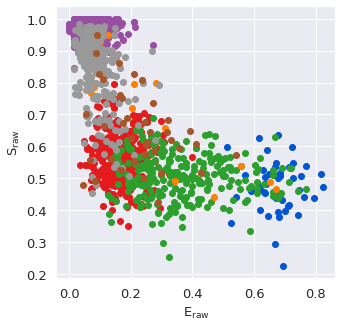

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
bhm.burst_ES_scatter(bdata.models[2], ax=ax)

Now this plot has a lot of colors in it, and they aren’t labeled. 
The number of colors scales with the square of the number of states, so you can imagine these plots get busy quickly. 
So there is an option: `flatten_dynamics`. 
Set this to `True` and then bursts will only be distinguished by whether any sort of transition occurs or if they only contain a single dwell/state:

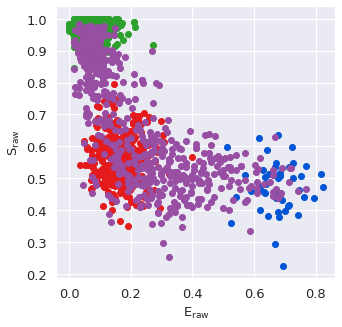

In [28]:
fig, ax = plt.subplots(figsize=(5,5))
bhm.burst_ES_scatter(bdata.models[2], flatten_dynamics=True,  ax=ax)

Finally, if you want to control the plotting by burst type, much like the state_kwargs keyword argument, there is the `type_kwargs` keyword argument. 
So, what is the order that the list needs to be given? 
Well that depends on if flatten_dynamics is `True` or `False`.

If it is `False`, then the order is based on the binary order, so it will go State0 only, then **State1** only, then **State1** and **State0**, then **State2** etc:

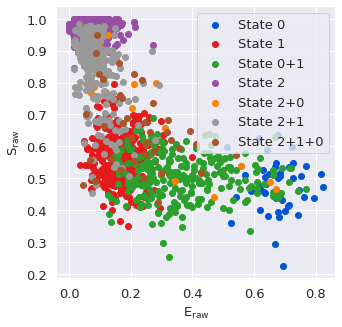

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
type_kwargs = [
    {'label':'State 0'}, {'label':'State 1'},
    {'label':'State 0+1'}, {'label':'State 2'},
    {'label':'State 2+0'}, {'label':'State 2+1'},
    {'label':'State 2+1+0'}
]
bhm.burst_ES_scatter(bdata.models[2],type_kwargs=type_kwargs, ax=ax)
ax.legend()

If `True` then the order is simply **State0**, **State1** … then finally, the last element will be “dynamic” bursts, i.e. a burst with any sort of dynamics:

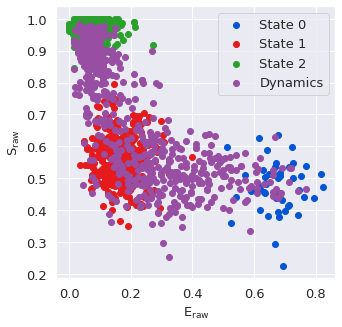

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
type_kwargs = [
    {'label':'State 0'}, {'label':'State 1'},
    {'label':'State 2'}, {'label':'Dynamics'}
]
bhm.burst_ES_scatter(bdata.models[2],flatten_dynamics=True, type_kwargs=type_kwargs, ax=ax)
ax.legend()